In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
from sklearn.model_selection import train_test_split
import random
import tensorflow_probability as tfp
import tensorflow_addons as tfa

# **Data Augmentation**

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import backend as K

batch_size= 32
image_size = [256, 256]


ds = image_dataset_from_directory(
    '../input/screwanomalies-detection/screw/train',
    labels=None,
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)

def convert_to_float(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image


def trans1(img):
    return tfa.image.rotate(tf.image.flip_left_right(tf.image.flip_up_down(img)),-.2,fill_mode="reflect",interpolation="bilinear")

def trans2(img):
    return tfa.image.rotate(img,-.2,fill_mode="reflect",interpolation="bilinear")

def trans3(img):
    return tfa.image.rotate(img,.2,fill_mode="reflect",interpolation="bilinear")
    
ds1,ds2,ds3,ds4 = ds,ds.map(trans2),ds.map(trans3),ds.map(trans1)

ds = ds1#.concatenate(ds2).concatenate(ds3)#.concatenate(ds4)

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds = (
    ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 320 files belonging to 1 classes.


2022-11-21 01:17:13.602459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 01:17:13.764998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 01:17:13.765947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 01:17:13.768344: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
ds_a = image_dataset_from_directory(
    '../input/screwanomalies-detection/screw/test/scratch_neck',
    labels=None,
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)
print(type(ds))

def convert_to_float(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_a = (
    ds_a
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 25 files belonging to 1 classes.
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


# **Making my model**

In [4]:
# custom invert gradiant for last layers decoder


@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return - 1* dy
    return y, custom_grad

In [5]:
a,b = image_size
shape=(a, b,3)


encoder_inputs = keras.Input(shape=shape)
x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.GaussianNoise(stddev=15)(x)
x = layers.MaxPooling2D(2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(.2)(x)

x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(.2)(x)

x = layers.Conv2D(65, 3, activation="relu", strides=1, padding="same")(x)


encoder = keras.Model(encoder_inputs, x, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      1568      
_________________________________________________________________
gaussian_noise (GaussianNois (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3283

In [6]:
a,b,c,d = x.shape
latent_inputs = keras.Input(shape=(b,c,d))

x = layers.Conv2DTranspose(256, 3, activation="relu", strides=1, padding="same")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(2)(x)
x = layers.Dropout(.2)(x)

x = layers.Conv2DTranspose(128, 5, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
#x = layers.UpSampling2D(2)(x)
x = layers.Dropout(.2)(x)

x = layers.Conv2DTranspose(64, 9, activation="relu", strides=4, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(32, 5, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2D(3, 5, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 16, 65)]      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       150016    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 256)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       819328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 128)       512 

In [7]:
discriminator_inputs = keras.Input(shape=shape)

x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(discriminator_inputs)
x = layers.MaxPooling2D(2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(.2)(x)

x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128,activation="relu")(x)
x = layers.Dropout(.2)(x)
x = layers.Dense(128,activation="relu")(x)
discriminator_outputs = layers.Dense(1,activation="sigmoid")(x)
discriminator = keras.Model(discriminator_inputs, discriminator_outputs, name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      1568      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)      

In [8]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        
    def call(self,x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z,reconstruction

    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            
            reconstruction = self.decoder(z_inv_grad)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))

            
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }

In [9]:
from keras import backend as K
class AE_GAN(keras.Model):    

    def __init__(self, encoder,decoder, discriminator, opti_vae=keras.optimizers.Adam(), opti_disc=keras.optimizers.Adam(), opti3=keras.optimizers.Adam(), **kwargs):
        super(AE_GAN, self).__init__(**kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator
        
        self.ae_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.correlation_loss_tracker = keras.metrics.Mean(name="cr_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.disc_loss = keras.losses.BinaryCrossentropy()
        
        self.ae_optimizer = opti_vae
        self.gen_optimizer = opti3
        self.disc_optimizer = opti_disc
        
    def call(self,x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z,reconstruction

    @property
    def metrics(self):
        return [
            self.ae_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.correlation_loss_tracker,
            self.disc_loss_tracker,
            self.gen_loss_tracker
        ]

    def train_step(self, data):        
        batch_size = K.shape(data)[0]    
        
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
            
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            
            
            # GAN
            #batch_size = 12
            #recon_vect = z#tf.random.normal((batch_size, latent_dim))
            contruction = reconstruction
            combined_images = tf.concat([data, contruction], axis=0)
            data_l,recon_l = tf.zeros((batch_size, 1)),tf.ones((batch_size, 1))
            combined_l = tf.concat([data_l, recon_l], axis=0)
            tot_predictions = self.discriminator(combined_images)
            r_prediction = self.discriminator(contruction)

            discr_loss = self.disc_loss(combined_l,tot_predictions)
            #fake labels : 
            #gen_loss =  self.disc_loss(recon_l,r_prediction)
            gen_loss = tf.math.maximum(self.disc_loss(data_l,r_prediction) - discr_loss,.0001)
        
            #=========
            ae_loss = reconstruction_loss  + gen_loss #+.1*coorelation_loss 

        grad_ae = enc_tape.gradient(ae_loss, self.encoder.trainable_weights+self.decoder.trainable_weights)       
        grad_discr = disc_tape.gradient(discr_loss, self.discriminator.trainable_weights)
        #grad_gen = dec_tape.gradient(gen_loss, self.decoder.trainable_weights)
        
        
        #self.gen_optimizer.apply_gradients(zip(grad_gen, self.decoder.trainable_weights))
        
        self.ae_optimizer.apply_gradients(zip(grad_ae,self.encoder.trainable_weights+self.decoder.trainable_weights))
        self.disc_optimizer.apply_gradients(zip(grad_discr, self.discriminator.trainable_weights))

                                           
        self.ae_loss_tracker.update_state(ae_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.disc_loss_tracker.update_state(discr_loss)
        self.gen_loss_tracker.update_state(gen_loss)
        
        return {
            "vae_loss": self.ae_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
            "gen_los": self.gen_loss_tracker.result(),
        }

# **Training**

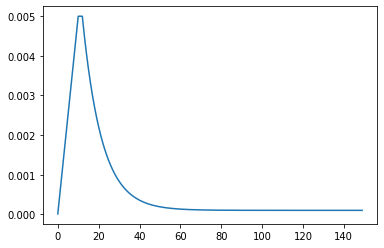

In [10]:
def get_lr_callback(epoch,lr):
    lr_start   = 0.00001
    lr_max     = 0.005#0.00000125 * 1 * batch_size
    lr_min     = 0.0001
    lr_ramp_ep = 10
    lr_sus_ep  = 2
    lr_decay   = 0.9
    cycle = 5
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    
    return lrfn(epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(get_lr_callback, verbose=True)
x = [x for x in range(150)]
plt.plot(x,[get_lr_callback(x,.1) for x in x])
plt.show()

In [11]:
model = AE_GAN(encoder,decoder, discriminator,opti_vae=keras.optimizers.Adam(), opti_disc=keras.optimizers.Adam())
model.compile()

In [12]:
history = model.fit(ds, epochs=250,verbose=1,callbacks=[lr_callback])

2022-11-21 01:17:18.328378: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.


2022-11-21 01:17:25.951800: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 19s 315ms/step - vae_loss: 43212.5188 - disc_loss: 0.7329 - gen_los: 0.0216
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005090000000000001.
10/10 [==============================] - 3s 307ms/step - vae_loss: 38688.0675 - disc_loss: 0.6872 - gen_los: 0.0113
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010080000000000002.
10/10 [==============================] - 3s 307ms/step - vae_loss: 37970.3352 - disc_loss: 0.6553 - gen_los: 0.0386
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015070000000000003.
10/10 [==============================] - 3s 308ms/step - vae_loss: 37398.1289 - disc_loss: 0.5823 - gen_los: 0.2454
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.0020060000000000004.
10/10 [==============================] - 3s 307ms/step - vae_loss: 36895.5220 - disc_loss: 0.5341 - gen_los: 0.6332
Epoch 6/250

Epoch 00006: LearningR

#  **Results Analyse**

<AxesSubplot:>

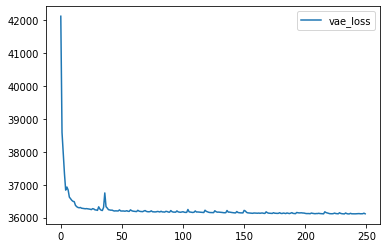

In [13]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['vae_loss']].plot()

# On training set

In [14]:
def diff(a,b):
    img = abs(a-b)
    treshhold = .2
    img = layers.Activation("relu")(img-treshhold)
    #m,M = tf.reduce_min(img),tf.reduce_max(img)
    #norm = (img-m)/(M-m)
    return layers.Activation("relu")(img)*255

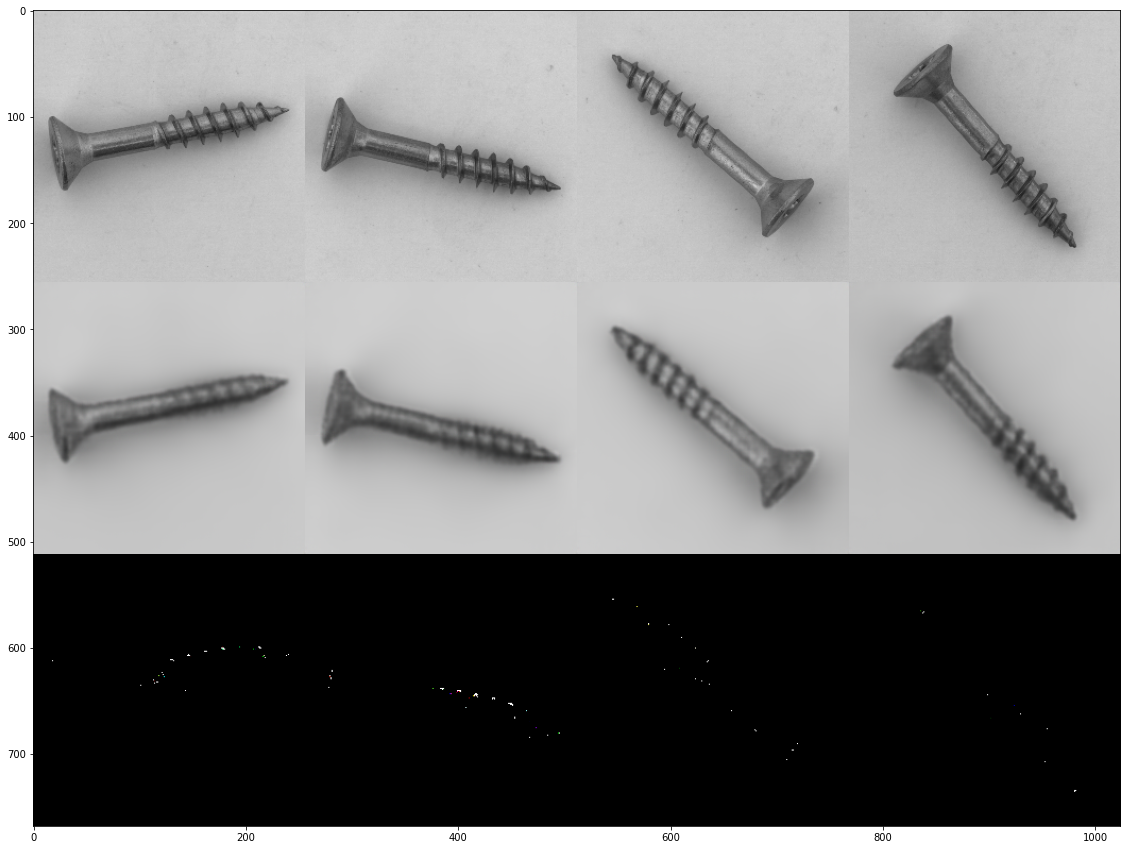

In [15]:
digit_size, _ = image_size
n = 4
figure = np.zeros((digit_size*3, digit_size * n,3))
img = list(ds)[0]

for i in range(n):
    _,b_img = model(img)
    a = list(b_img)[i]
    figure[
                 0*digit_size :  digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = list(img)[i]
    figure[
                 1*digit_size :  2*digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = a
    
    figure[
                 2*digit_size :  3*digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = diff(a,list(img)[i])


figsize = 5   
plt.figure(figsize=(figsize*n, figsize*3))
plt.imshow(figure)
plt.show()

# On test set

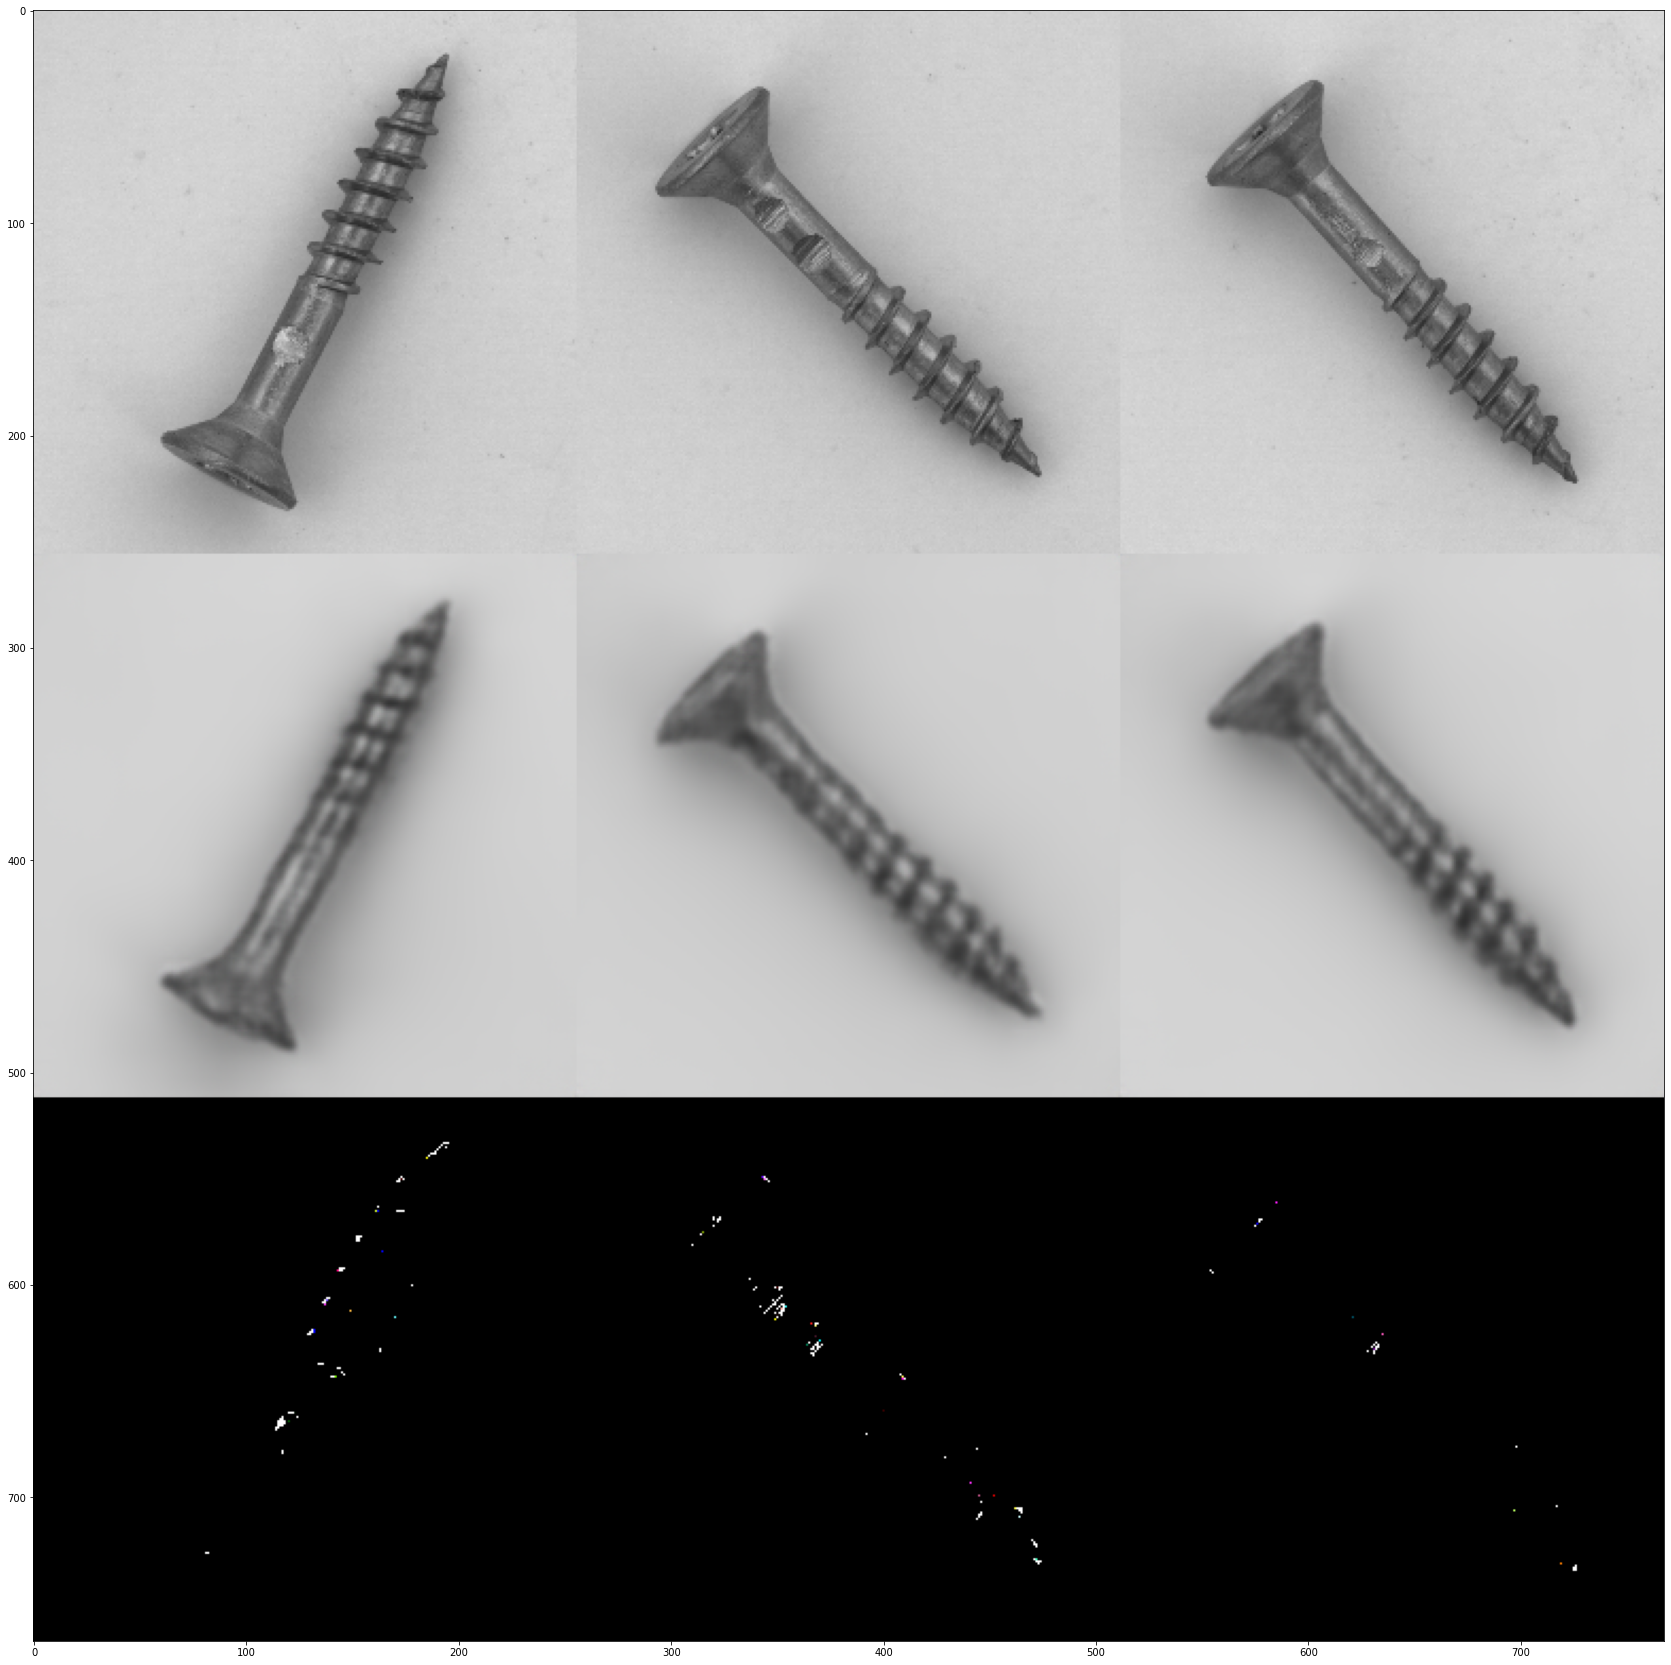

In [16]:
n = 3

figure = np.zeros((digit_size*3, digit_size * n,3))
img = list(ds_a)[0]
for i in range(n):
    _,b_img = model(img)
    a = list(b_img)[i]
    figure[
                 0*digit_size :  digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = list(img)[i]
    figure[
                 1*digit_size :  2*digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = a
    
    figure[
                 2*digit_size :  3*digit_size,
                i * digit_size :  (i+1)* digit_size,
            ] = diff(a,list(img)[i])

figsize = 10  
plt.figure(figsize=(figsize*n, figsize*3))
plt.imshow(figure)
plt.show()

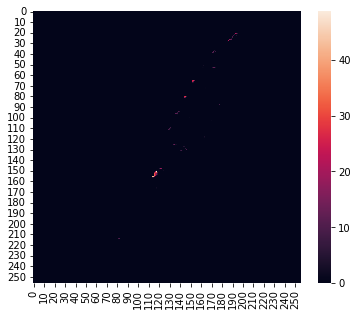

In [17]:
import seaborn as sns
i = 0
_,b_img = model(img)
a = list(b_img)[i]
im = diff(a,list(img)[i])
im  = tf.math.reduce_mean(im,2)
f, ax = plt.subplots(figsize=(6, 5))
f = sns.heatmap(im)

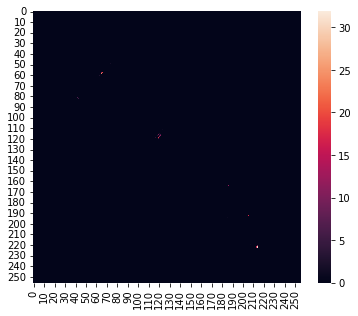

In [18]:
i = 2
_,b_img = model(img)
a = list(b_img)[i]
im = diff(a,list(img)[i])
im  = tf.math.reduce_mean(im,2)
f, ax = plt.subplots(figsize=(6, 5))
f = sns.heatmap(im)